# Dimension

While the majority of `momepy` functions require interaction of more `GeoDataFrames` or using spatial weights matrix, there are some which are calculated on single `GeoDataFrame` assessing the dimensions or shapes of features. This notebook illustrates this group on small part of Manhattan, New York.

In [1]:
import matplotlib.pyplot as plt
import momepy

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. You can show the code with the button on the right side.

In [2]:
import osmnx as ox

point = (40.731603, -73.977857)
dist = 1000
gdf = ox.geometries.geometries_from_point(
    point, dist=dist, tags={"building": True}
)
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[
    gdf_projected.geom_type.isin(["Polygon", "MultiPolygon"])
]

buildings["uID"] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tess = momepy.Tessellation(buildings, unique_id="uID", limit=limit)
tessellation = tess.tessellation

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/Users/martin/Git/momepy/momepy/elements.py:386: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [217, 405, 833, 835, 1994, 3053, 3056, 3070, 3136, 3147, 3157, 3163]
  warnings.warn(


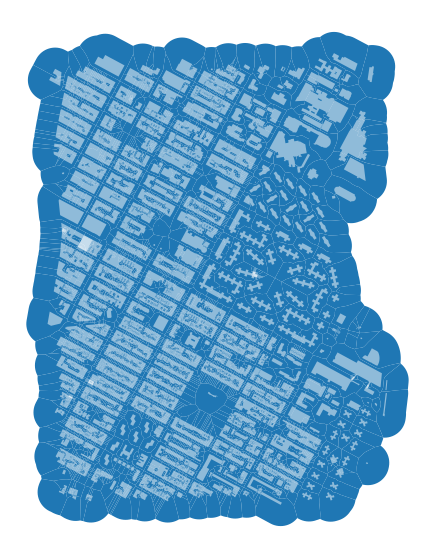

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

We have some edge effect here as we are using the buffer as a limit for tessellation in the middle of urban fabric, but for this examples we can work with it anyway.

## Area
Some work the same for more elements (buildings, tessellation, plots) like area, some makes sense only for a relevant ones. Area works for both, buildings and tessellation of our case study.

Resulting values can be accessed using `area` attribute, while original gdf using `gdf`.

In [4]:
blg_area = momepy.Area(buildings)
buildings["area"] = blg_area.series

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


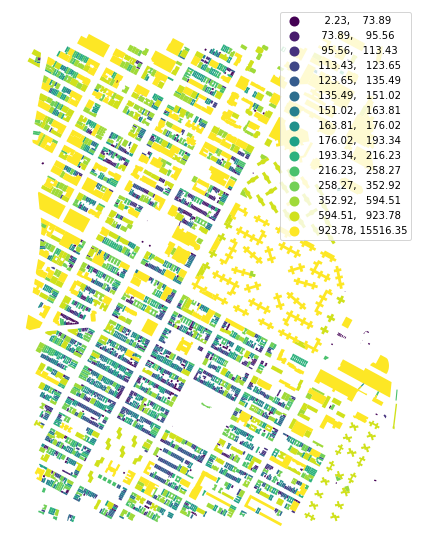

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax, column="area", legend=True, scheme="quantiles", k=15, cmap="viridis"
)
ax.set_axis_off()
plt.show()

In [6]:
tes_area = momepy.Area(tessellation)
tessellation["area"] = tes_area.series

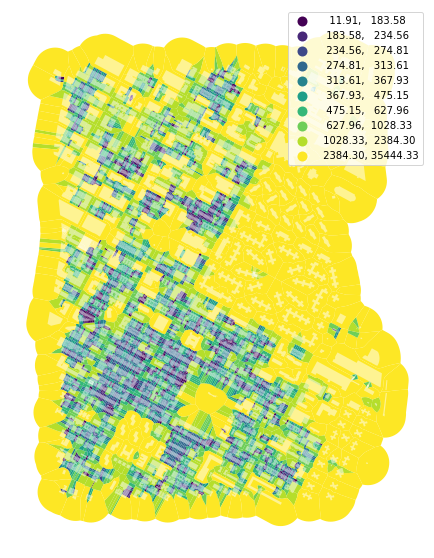

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax, column="area", legend=True, scheme="quantiles", k=10, cmap="viridis"
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

## Height

We can also work with building heights (if we have the data). This part of New York has height data, only stored as strings, so we have to convert them to `floats` (or `int`) and fill `NaN` values with zero. Since some height attrbutes may be incorrectly defined in OSM, we use try/except to filter potential issues.

In [8]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


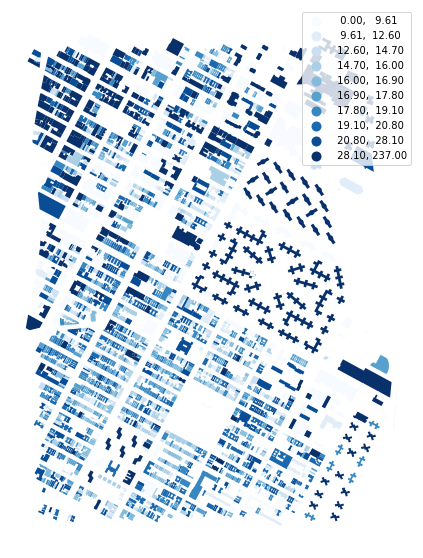

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax, column="height", scheme="quantiles", k=10, legend=True, cmap="Blues"
)
ax.set_axis_off()
plt.show()

There are not many simple characters we can do with height, but `Volume` is possible. Unlike before, you have to pass the name of the column, `np.array`, or `pd.Series` where is stored height value. We have a column already.

In [10]:
blg_volume = momepy.Volume(buildings, heights="height")
buildings["volume"] = blg_volume.series

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


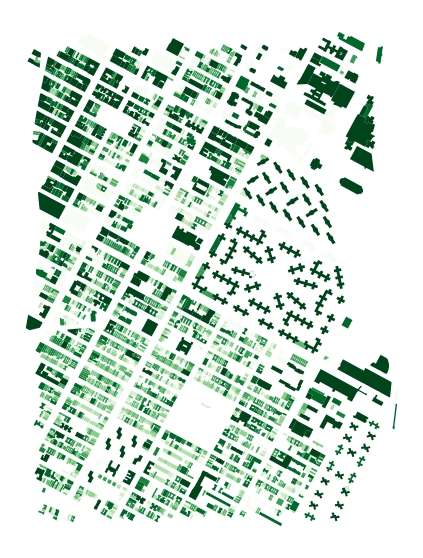

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="volume",
    legend=False,
    scheme="quantiles",
    k=10,
    cmap="Greens",
)
ax.set_axis_off()
plt.show()

Overview of all characters is available in [API](https://docs.momepy.org/en/latest/api.html), with additional examples of usage. Some characters make sense to calculate only in specific cases. Prime example is `CourtyarArea` - there are many places where all buildings are courtyard-less, resulting in a `Series` full of zeros.